# 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), ".."))

In [3]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [5]:

from certainty import EventSentence, load_file, convert_events, EventType, bootstrap_metrics

2025-04-08 11:29:44.215452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 11:29:44.251039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 11:29:45.028914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
sns.set_theme(rc={'figure.figsize':(11.7,4.27)})

In [7]:
ace_train = load_file("en_train.json")
ace_dev = load_file("en_dev.json")
ace_test = load_file("en_test.json")

In [8]:
dev_data = pd.DataFrame(ace_dev).drop_duplicates('text').drop_duplicates('events')
dev_events = list(convert_events(dev_data.to_dict('records')))

In [9]:
dev_df = pd.DataFrame(dev_events)

In [10]:
dev_df.describe()

,label
count,496.000000
mean,0.717742
std,0.450553
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
train_data = pd.DataFrame(ace_train).drop_duplicates('text').drop_duplicates('events')
train_events = list(convert_events(train_data.to_dict('records')))
train_df = pd.DataFrame(train_events)

In [12]:
misclassified_trigger = pd.read_csv('../results/baseline_misclassified_trigger.csv').drop_duplicates("Input Text")
misclassified_type = pd.read_csv('../results/baseline_misclassified_type.csv').drop_duplicates("Input Text")

In [13]:
misclassified_trigger.head()

,Input Text,True Label,Predicted Label,Event type
0,[head over]: As they get ready to head over ho...,Other,Asserted,Transport
1,[strike]: Eight hundred of those sorties will ...,Asserted,Other,Attack
2,[killed]: The Apache troop opened its tank gun...,Other,Asserted,Die
3,"[fight]: Earlier in the day, the 1st Brigade o...",Asserted,Other,Attack
4,[combat]: The coalition air force will begin p...,Other,Asserted,Attack


In [14]:
misclassified_type.head()

,Input Text,True Label,Predicted Label,Event type
0,"[Transport, head over]: As they get ready to h...",Other,Asserted,Transport
1,"[Attack, strike]: Eight hundred of those sorti...",Asserted,Other,Attack
2,"[Attack, fight]: Earlier in the day, the 1st B...",Asserted,Other,Attack
3,"[Attack, battle]: The intensity it's very quic...",Asserted,Other,Attack
4,"[Transport, deploy]: Orders went out today to ...",Other,Asserted,Transport


In [15]:
def remove_bracketed_text(text):
    return re.sub(r'\[[^,\]]+,\s*', '[', text)

# Apply the function
misclassified_type['modInput'] = misclassified_type["Input Text"].apply(remove_bracketed_text)

In [16]:
matching_df = misclassified_type[misclassified_type["modInput"].isin(misclassified_trigger["Input Text"])]  # Elements in both DataFrames
non_matching_df = misclassified_type[~misclassified_type["modInput"].isin(misclassified_trigger["Input Text"])]  # Elements only in df1

In [17]:
matching_df.head()

,Input Text,True Label,Predicted Label,Event type,modInput
0,"[Transport, head over]: As they get ready to h...",Other,Asserted,Transport,[head over]: As they get ready to head over ho...
1,"[Attack, strike]: Eight hundred of those sorti...",Asserted,Other,Attack,[strike]: Eight hundred of those sorties will ...
2,"[Attack, fight]: Earlier in the day, the 1st B...",Asserted,Other,Attack,"[fight]: Earlier in the day, the 1st Brigade o..."
4,"[Transport, deploy]: Orders went out today to ...",Other,Asserted,Transport,"[deploy]: Orders went out today to deploy 17,0..."
6,"[Attack, invasion]: The more they learn about ...",Other,Asserted,Attack,[invasion]: The more they learn about this inv...


In [18]:
non_matching_df.describe()

,Input Text,True Label,Predicted Label,Event type,modInput
count,15,15,15,15,15
unique,15,2,2,6,15
top,"[Attack, battle]: The intensity it's very quic...",Asserted,Other,Attack,[battle]: The intensity it's very quick moving...
freq,1,8,8,9,1


In [19]:

def plot_misclassification_chart(misclassified, dev_df):
    other_value_counts = misclassified[misclassified["True Label"]=="Other"]['Event type'].value_counts()
    asserted_value_counts = misclassified[misclassified["True Label"]=="Asserted"]['Event type'].value_counts()
    df = pd.DataFrame()
    #mis_series = (misclassified_type['Event type'].value_counts() / dev_df['type'].value_counts()).fillna(0)
    df["asserted_misclassified"] = (asserted_value_counts / dev_df[dev_df["modality"] == "Asserted"]['type'].value_counts()).fillna(0)
    df["other_misclassified"] = -(other_value_counts / dev_df[dev_df["modality"] == "Other"]['type'].value_counts()).fillna(0)
    #df["type"] = list(mis_series.index.to_series())
    # df["percent_misclassified"] =  list(mis_series)
    df["other_misclassified"] = df["other_misclassified"].fillna(0)
    # df = df.sort_values(by=["other_misclassified", "asserted_misclassified"], ascending=True)
    df = df.sort_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    
    sns.barplot(y=df.index, x=df["asserted_misclassified"], color=sns.color_palette("pastel")[0], label="Asserted Misclassified", ax=ax)
    sns.barplot(y=df.index, x=df["other_misclassified"], color=sns.color_palette("pastel")[1], label="Other Misclassified", ax=ax)
    # Add labels and title
    ax.set_xlabel("Misclassification Ratio relative to whole validation set")
    ax.set_ylabel("Event Type")
    ax.set_title("Misclassification Rates by Event Type and modality")
    ax.set_xticks([-1.0, -0.5, -0.25, 0, 0.25, 0.5, 1.0])  # Adjust based on range
    ax.set_xticklabels(["1.0", "0.5", "0.25", "0", "0.25", "0.5", "1.0"])
    ax.legend()
    return fig

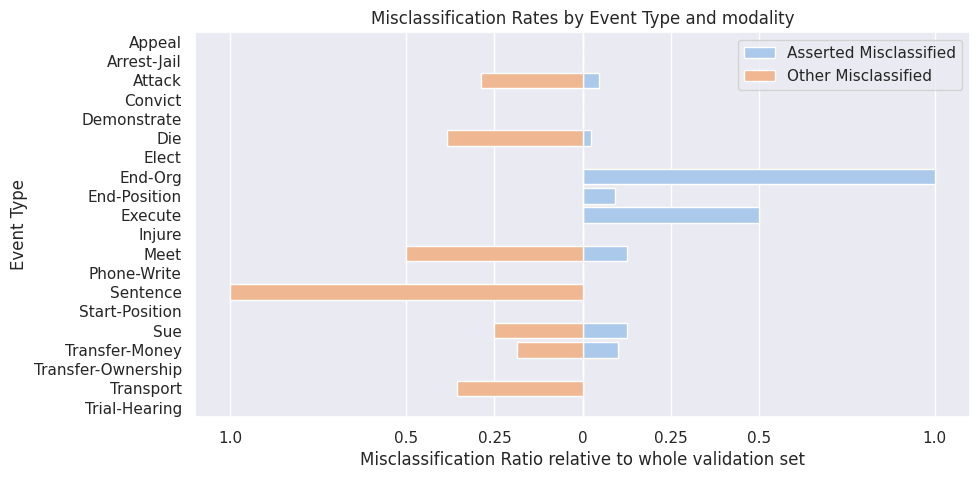

In [20]:
fig = plot_misclassification_chart(matching_df, dev_df)
fig.savefig('../results/matching_misclassification.png')

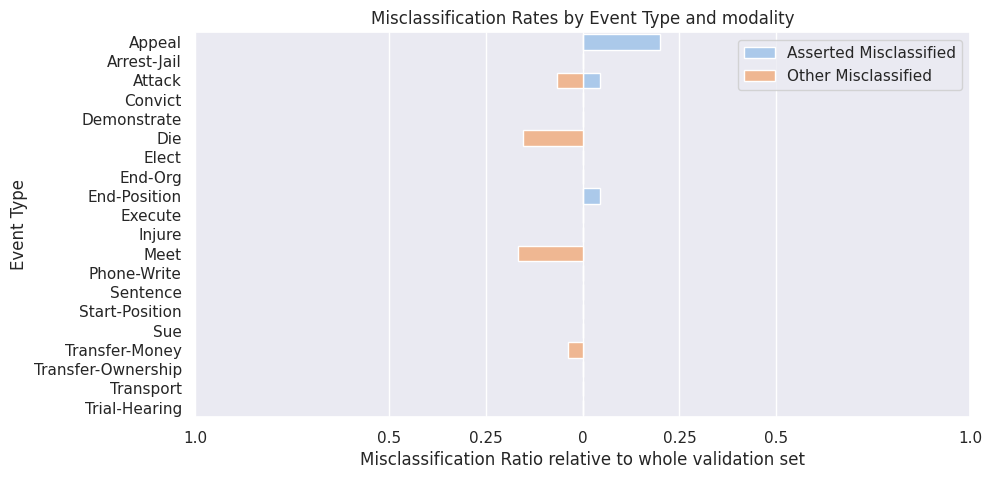

In [21]:
fig = plot_misclassification_chart(non_matching_df, dev_df)
fig.savefig('../results/non_matching_misclassification.png')

In [22]:
non_matching_df

,Input Text,True Label,Predicted Label,Event type,modInput
3,"[Attack, battle]: The intensity it's very quic...",Asserted,Other,Attack,[battle]: The intensity it's very quick moving...
5,"[Attack, war]: Any rational person hates war",Other,Asserted,Attack,[war]: Any rational person hates war
9,"[Attack, warfare]: Still to come : warfare ami...",Asserted,Other,Attack,[warfare]: Still to come : warfare amid the ce...
16,"[Attack, battle]: US Secretary of Defense Dona...",Asserted,Other,Attack,[battle]: US Secretary of Defense Donald Rumsf...
21,"[Attack, war]: He repeated that Moscow would n...",Other,Asserted,Attack,[war]: He repeated that Moscow would not back ...
22,"[Appeal, appeals]: If we execute them now we c...",Asserted,Other,Appeal,[appeals]: If we execute them now we can't bri...
28,"[Die, death]: Use of the death penalty is rare...",Other,Asserted,Die,[death]: Use of the death penalty is rare in I...
32,"[Attack, war]: For these reasons, we judge tha...",Other,Asserted,Attack,"[war]: For these reasons, we judge that it is ..."
35,"[Attack, retaliation]: Israeli media said the ...",Asserted,Other,Attack,[retaliation]: Israeli media said the retaliat...
51,"[End-Position, resigning]: He was asked to wai...",Asserted,Other,End-Position,[resigning]: He was asked to wait until after ...


In [23]:
matching_df['Event type'].value_counts()

Attack                19
Transfer-Money         7
Meet                   6
Die                    6
Transport              5
Sue                    2
End-Position           2
End-Org                1
Declare-Bankruptcy     1
Execute                1
Sentence               1
Charge-Indict          1
Name: Event type, dtype: int64

In [24]:
matching_df[matching_df['Event type'] == 'Declare-Bankruptcy']['Input Text'].tolist()

['[Declare-Bankruptcy, bankruptcy]: despite operating under bankruptcy laws, united posted the best on time performance']

In [25]:
matching_df[matching_df['Event type'] == 'Declare-Bankruptcy']

,Input Text,True Label,Predicted Label,Event type,modInput
12,"[Declare-Bankruptcy, bankruptcy]: despite oper...",Other,Asserted,Declare-Bankruptcy,[bankruptcy]: despite operating under bankrupt...


<AxesSubplot: xlabel='Predicted Label', ylabel='Count'>

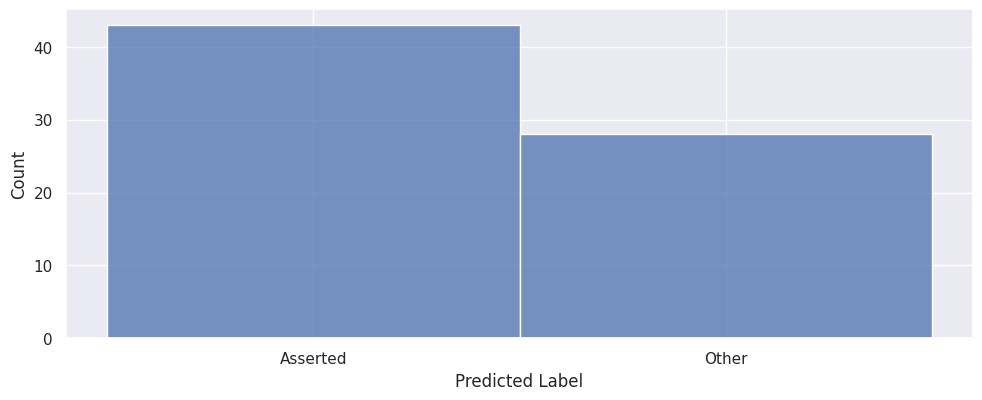

In [26]:
sns.histplot(misclassified_trigger['Predicted Label'])

<AxesSubplot: xlabel='Event type', ylabel='Count'>

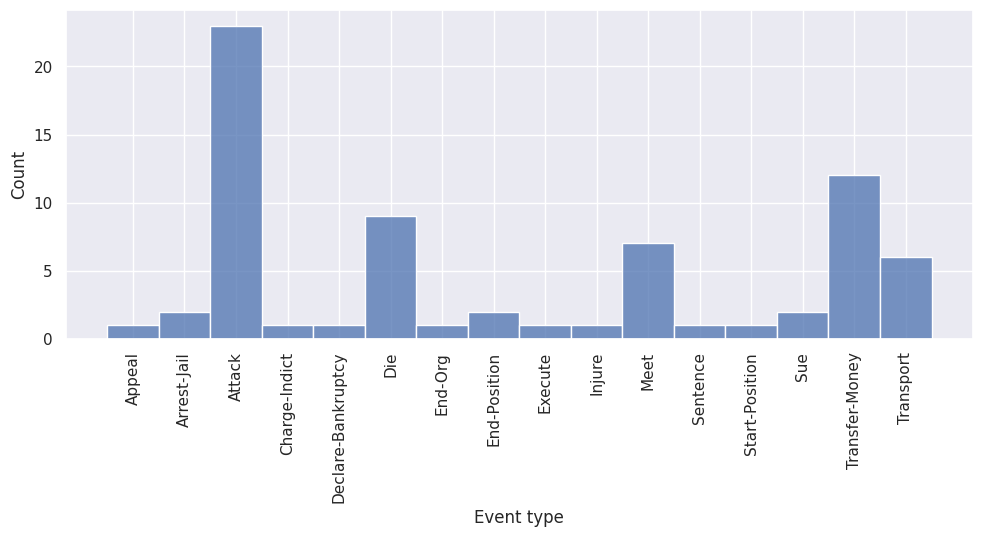

In [27]:
plt.xticks(rotation=90)
sns.histplot(misclassified_trigger['Event type'].sort_values())

In [28]:
ratio = misclassified_trigger['Input Text'].count() / dev_df['text'].count()

<AxesSubplot: >

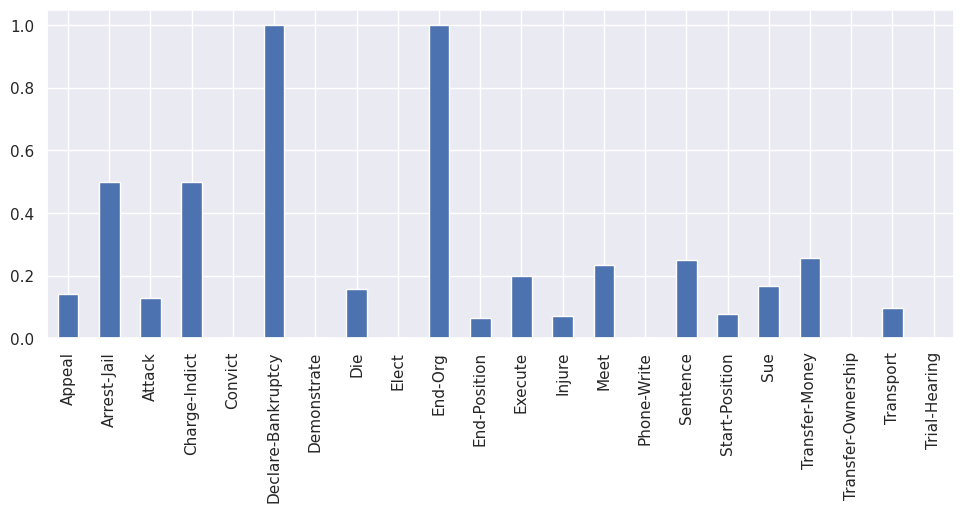

In [29]:
(misclassified_trigger['Event type'].value_counts() / dev_df['type'].value_counts()).fillna(0).plot.bar()

In [30]:

def plot_misclassification_chart_absolute(misclassified, dev_df):
    # Get all unique event types
    all_event_types = dev_df['type'].unique()

    # Get raw misclassified counts
    other_value_counts = misclassified[misclassified["True Label"] == "Other"]['Event type'].value_counts()
    asserted_value_counts = misclassified[misclassified["True Label"] == "Asserted"]['Event type'].value_counts()
    
    # Create DataFrame with all event types, ensuring missing ones are filled with 0
    df = pd.DataFrame(index=all_event_types)
    df["asserted_misclassified"] = asserted_value_counts.reindex(all_event_types, fill_value=0)  # Positive (right side)
    df["other_misclassified"] = -other_value_counts.reindex(all_event_types, fill_value=0)  # Negative (left side)

    # Sort by "asserted_misclassified" (descending) then "other_misclassified" (ascending)
    df = df.sort_index()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.barplot(y=df.index, x=df["asserted_misclassified"], color=sns.color_palette("pastel")[0], label="Asserted Misclassified", ax=ax)
    sns.barplot(y=df.index, x=df["other_misclassified"], color=sns.color_palette("pastel")[1], label="Other Misclassified", ax=ax)
    
    # Labels and title
    ax.set_xlabel("Absolute Misclassification Count")
    ax.set_ylabel("Event Type")
    ax.set_title("Absolute Misclassification Counts by Event Type and Modality")
    
    # Set fixed x-axis limits (0 to 17)
    ax.set_xlim(-17, 17)
    ax.set_xticks(range(-17, 18, 2))  # Tick marks every 2 units
    ax.set_xticklabels([str(abs(x)) for x in ax.get_xticks()])  # Show absolute values
    
    ax.legend()
    
    return fig
    
   

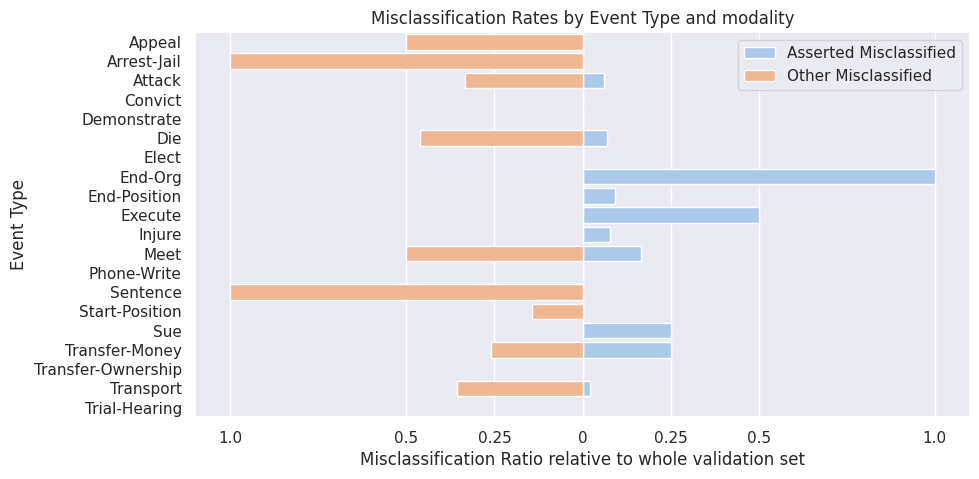

In [31]:
fig = plot_misclassification_chart(misclassified_trigger, dev_df)
fig.savefig('../results/misclassified_trigger')

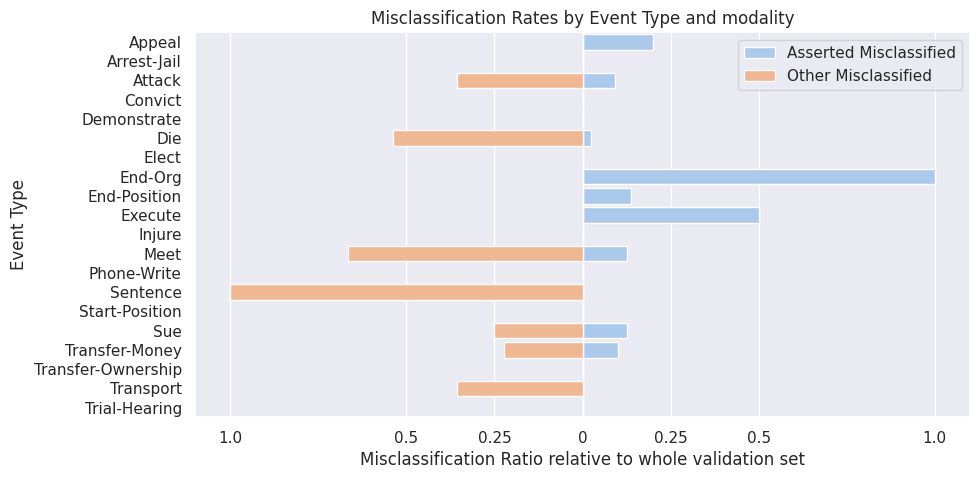

In [32]:
fig = plot_misclassification_chart(misclassified_type, dev_df)
fig.savefig('../results/misclassified_type')

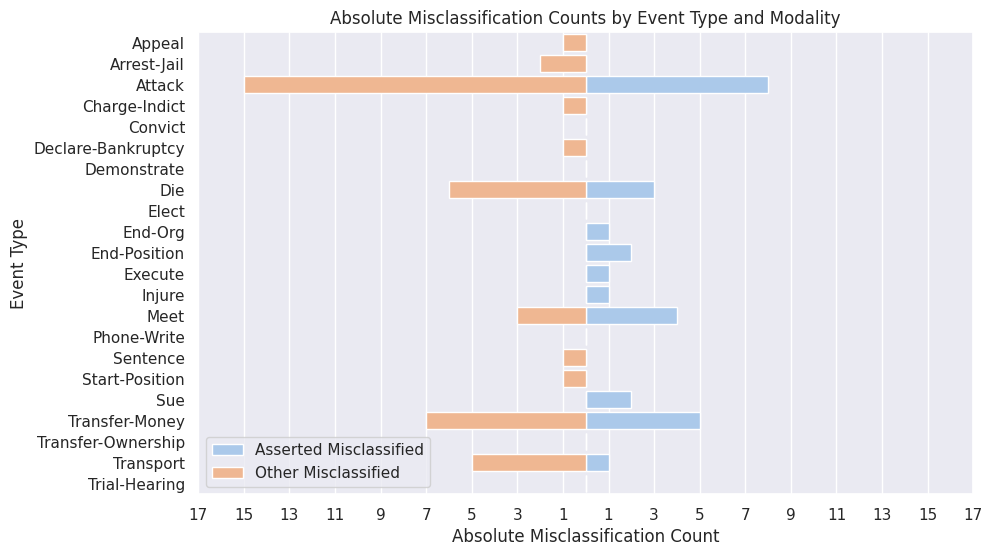

In [33]:
fig = plot_misclassification_chart_absolute(misclassified_trigger, dev_df)
fig.savefig('../results/absolute_misclassified_trigger')

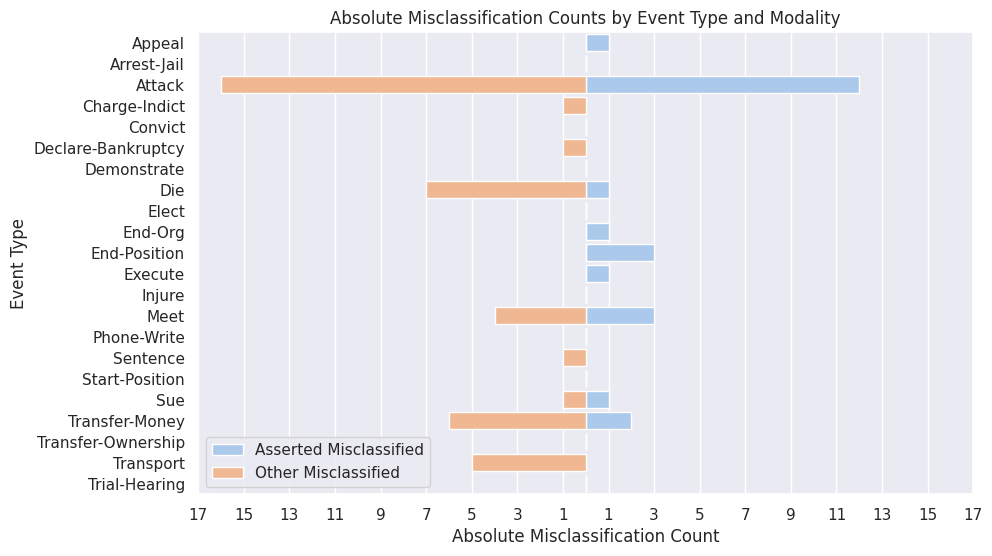

In [34]:
fig = plot_misclassification_chart_absolute(misclassified_type, dev_df)
fig.savefig('../results/absolute_misclassified_type')

In [35]:
mj_baseline = pd.read_csv('../results/majority_baseline.csv', index_col=0)

In [36]:
mj_baseline

,Majority class
Precision Asserted,0.717742
Precision Other,0.000000
Recall Asserted,1.000000
Recall Other,0.000000
f1 Asserted,0.835681
f1 Other,0.000000
Accuracy,0.717742


In [92]:
def print_metrics(df):
    P = 356
    N = 140
    total = 496
    TP = df['eval/recall']*P
    FP = TP/(df['eval/precision'])-TP
    FN = TP/(df['eval/recall'])-TP
    TN = (df['eval/accuracy']*(TP + FP + FN) - TP)/(1-df['eval/accuracy'])
    recall_0 = TN/(TN+FP)
    precision_0 = TN/(TN+FN)
    df['eval/recall_class_0'] = recall_0
    df['eval/precision_class_0'] = precision_0
    df['Macro avg precision'] = (df['eval/precision']+df['eval/precision_class_0'])/2
    df['Macro avg recall'] = (df['eval/recall']+df['eval/recall_class_0'])/2
    df['Macro avg f1'] = (df['eval/f1']+df['eval/f1_class_0'])/2
    df['Weighted avg precision'] = ((P/total)*df['eval/precision']+(N/total)*df['eval/precision_class_0'])
    df['Weighted avg recall'] = ((P/total)*df['eval/recall']+(N/total)*df['eval/recall_class_0'])
    df['Weighted avg f1'] = ((P/total)*df['eval/f1']+(N/total)*df['eval/f1_class_0'])
    stats_df = df.describe().loc[['mean', 'std']][['eval/f1', 
                                                                     'eval/f1_class_0', 
                                                                     'eval/accuracy', 
                                                                     'eval/recall', 
                                                                     'eval/recall_class_0', 
                                                                     'eval/precision', 
                                                                     'eval/precision_class_0', 
                                                                     'Macro avg precision',
                                                                     'Macro avg recall',
                                                                     'Macro avg f1',
                                                                     'Weighted avg precision',
                                                                     'Weighted avg recall',
                                                                     'Weighted avg f1',
                                                                         ]]
    stats_df = stats_df*100
    stats_df=stats_df.rename(columns={"eval/f1": "f1 Asserted", "eval/f1_class_0": "f1 Other", "eval/accuracy": "Accuracy", "eval/recall": "Recall Asserted", "eval/precision": "Precision Asserted", "eval/precision_class_0": "Precision Other", "eval/recall_class_0": "Recall Other"}).T
    stats_df['mean_numeric'] = pd.to_numeric(stats_df['mean'], errors='coerce')
    stats_df['std_numeric'] = pd.to_numeric(stats_df['std'], errors='coerce')

    stats_df['mean_std'] = stats_df.apply(
        lambda row: f"{row['mean_numeric']:.1f} ± {row['std_numeric']:.1f}" 
        if pd.notna(row['mean_numeric']) and pd.notna(row['std_numeric'])
        else f"{row['mean']} ± {row['std']}",  # Keep original format for Runtime
        axis=1
    )
    
    stats_df['With trigger'] = stats_df['mean_std']

    metrics = stats_df[['With trigger']]
    print(metrics.T[['Precision Asserted', 'Recall Asserted', 'f1 Asserted']].to_latex())
    print(metrics.T[['Precision Other', 'Recall Other', 'f1 Other']].to_latex())
    print(metrics.T[['Macro avg precision', 'Macro avg recall', 'Macro avg f1']].to_latex())
    print(metrics.T[['Weighted avg precision', 'Weighted avg recall', 'Weighted avg f1']].to_latex())

In [93]:
df = pd.read_csv('../results/metrics_baseline_trigger_and_type.csv')
print_metrics(df[df['trigger'] == 'trigger'])

\begin{tabular}{llll}
\toprule
{} & Precision Asserted & Recall Asserted & f1 Asserted \\
\midrule
With trigger &         88.0 ± 0.6 &      90.6 ± 1.3 &  89.3 ± 0.9 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Precision Other & Recall Other &    f1 Other \\
\midrule
With trigger &      74.3 ± 3.0 &   68.7 ± 1.5 &  71.4 ± 2.2 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Macro avg precision & Macro avg recall & Macro avg f1 \\
\midrule
With trigger &          81.2 ± 1.8 &       79.7 ± 1.4 &   80.3 ± 1.5 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Weighted avg precision & Weighted avg recall & Weighted avg f1 \\
\midrule
With trigger &             84.2 ± 1.3 &          84.4 ± 1.3 &      84.2 ± 1.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21239/1874883480.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eval/recall_class_0'] = recall_0
/tmp/ipykernel_21239/1874883480.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eval/precision_class_0'] = precision_0
/tmp/ipykernel_21239/1874883480.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [96]:
print_metrics(df[df['trigger'] == 'type'])

\begin{tabular}{llll}
\toprule
{} & Precision Asserted & Recall Asserted & f1 Asserted \\
\midrule
With trigger &         88.9 ± 0.8 &      91.1 ± 1.0 &  90.0 ± 0.4 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Precision Other & Recall Other &    f1 Other \\
\midrule
With trigger &      75.9 ± 1.6 &   71.0 ± 2.5 &  73.3 ± 1.1 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Macro avg precision & Macro avg recall & Macro avg f1 \\
\midrule
With trigger &          82.4 ± 0.8 &       81.1 ± 0.9 &   81.7 ± 0.7 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Weighted avg precision & Weighted avg recall & Weighted avg f1 \\
\midrule
With trigger &             85.2 ± 0.6 &          85.4 ± 0.5 &      85.3 ± 0.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21239/1874883480.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eval/recall_class_0'] = recall_0
/tmp/ipykernel_21239/1874883480.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eval/precision_class_0'] = precision_0
/tmp/ipykernel_21239/1874883480.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

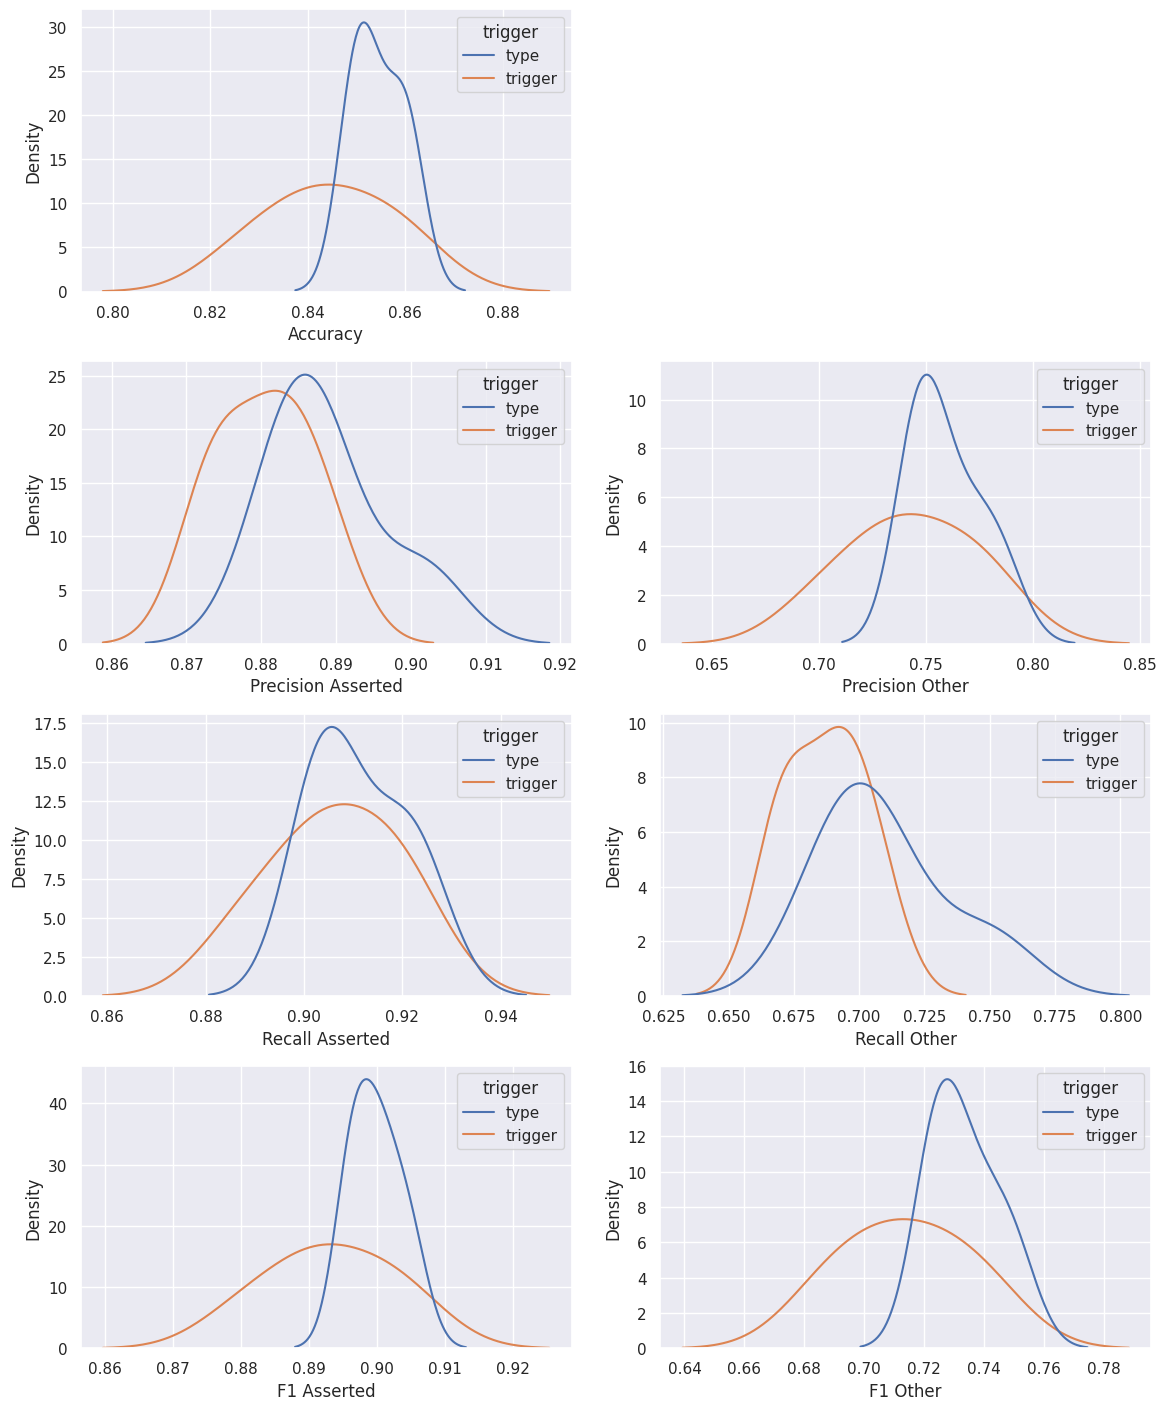

In [126]:
sns.set_theme(rc={'figure.figsize':(11.7, 14.27)})

f, axes = plt.subplots(4, 2)
sns.kdeplot(data=df, x="eval/accuracy", hue="trigger", ax=axes[0][0])
axes[0][1].remove()  # Remove the empty second subplot in the first row
sns.kdeplot(data=df, x="eval/precision", hue="trigger", ax=axes[1][0])
sns.kdeplot(data=df, x="eval/precision_class_0", hue="trigger", ax=axes[1][1])
sns.kdeplot(data=df, x="eval/recall", hue="trigger", ax=axes[2][0])
sns.kdeplot(data=df, x="eval/recall_class_0", hue="trigger", ax=axes[2][1])
sns.kdeplot(data=df, x="eval/f1_class_1", hue="trigger", ax=axes[3][0])
sns.kdeplot(data=df, x="eval/f1_class_0", hue="trigger", ax=axes[3][1])

# Rename x-axis for the last two plots
axes[0][0].set_xlabel("Accuracy")
axes[1][0].set_xlabel("Precision Asserted")
axes[1][1].set_xlabel("Precision Other")
axes[2][0].set_xlabel("Recall Asserted")
axes[2][1].set_xlabel("Recall Other")
axes[3][0].set_xlabel("F1 Asserted")
axes[3][1].set_xlabel("F1 Other")

# Adjust layout to prevent overlap
plt.tight_layout()

f.savefig("../results/baseline_metrics.png", dpi=300)  # Save with high resolution

In [127]:
from sklearn.metrics import confusion_matrix


In [128]:
dev_df['Input Text'] = '['+dev_df['trigger']+']: ' + dev_df['text']

In [129]:
dev_modalities = dev_df['modality']

In [131]:
mis_modalities = misclassified_trigger['True Label']

In [132]:
mis_modalities.value_counts()

Other       43
Asserted    28
Name: True Label, dtype: int64

In [133]:
true = dev_modalities.value_counts()-mis_modalities.value_counts()

In [134]:
false = mis_modalities = misclassified_trigger['Predicted Label']

In [135]:
false.value_counts()

Asserted    43
Other       28
Name: Predicted Label, dtype: int64

In [136]:
true

Asserted    328
Other        97
dtype: int64

In [137]:
import numpy as np

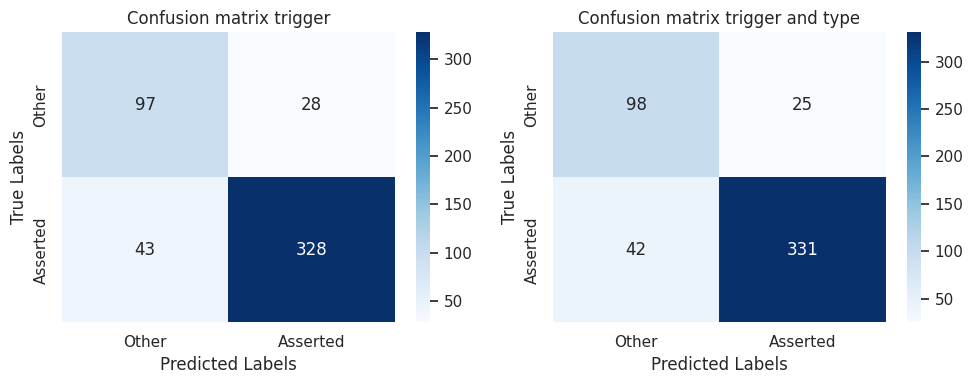

In [139]:

sns.set_theme(rc={'figure.figsize':(10, 4)})

conf_matrix_trigger = np.array([[97,  28],
                      [ 43, 328]])

conf_matrix_type = np.array([[98, 25],
                       [42, 331]])

class_labels = ["Other", "Asserted"]


f, axes = plt.subplots(1, 2)

sns.heatmap(conf_matrix_trigger, fmt="", annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])

# Labels and title
axes[0].set_title("Confusion matrix trigger")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

sns.heatmap(conf_matrix_type, fmt="", annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])

# Labels and title
axes[1].set_title("Confusion matrix trigger and type")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
plt.tight_layout()
f.savefig("../results/confusion_bert_baseline.png", dpi=300)


In [141]:
true = dev_modalities.value_counts()-misclassified_type['True Label'].value_counts()

In [142]:
true

Asserted    331
Other        98
dtype: int64

In [143]:
false = misclassified_type['Predicted Label'].value_counts()

In [144]:
false

Asserted    42
Other       25
Name: Predicted Label, dtype: int64

In [145]:
# Create a confusion matrix: Event Type vs. Predicted Label
conf_matrix = pd.crosstab(df["Event type"], df["Predicted Label"])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix: Event Type vs. Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("Event Type")
plt.show()

KeyError: 'Event type'